In [2]:
# Getting the list for training and testing of MSD dataset with SSL4MIS

import os

train_file = open("train.txt", "w")
val_file = open("test.txt", "w")

filenames = open("/home/major/Major-Project-Experiments/models/SSL4MIS/data/MSD/train.txt", "r").read().strip().split("\n")
for filename in filenames:
    train_file.write("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/"+filename+"_0000.nii.gz\n")
for image in os.listdir("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTs"):
    train_file.write("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTs/"+image+'\n')
train_file.close()
filenames = open("/home/major/Major-Project-Experiments/models/SSL4MIS/data/MSD/val.txt", "r").read().strip().split("\n")
for filename in filenames:
    val_file.write("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/"+filename+"_0000.nii.gz\n")
val_file.close()

In [23]:
# Visualising the masks and training data

import SimpleITK as sitk
images = []
spacings = []
origins = []
directions = []


itk_image = sitk.ReadImage("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/pancreas_001_0000.nii.gz")
spacings.append(itk_image.GetSpacing())
origins.append(itk_image.GetOrigin())
directions.append(itk_image.GetDirection())
npy_image = sitk.GetArrayFromImage(itk_image)

In [2]:
img_name = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/pancreas_001_0000.nii.gz"
import os

def rename_and_modify(filepath):
    """Renames the file, replacing 'imagesTr' with 'labelsTr' and removing the '_0000' part."""

    # Split the filepath into parts
    directory, filename = os.path.split(filepath)
    base, extension = os.path.splitext(filename)

    # Remove the "_0000"  substring 
    if base.endswith('_0000'):
        base = base[:-5]  

    # Construct the new filename
    new_filename = base.replace('imagesTr', 'labelsTr') + extension

    # Join the new filename with the directory
    new_filepath = os.path.join(directory, new_filename)

    # Rename the file
    return new_filepath

# Example usage (assuming your files are in the specified directory)
# data_dir = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/"

# for root, _, files in os.walk(data_dir):
#     for file in files:
#         if file.endswith(".nii.gz"):
#             filepath = os.path.join(root, file)
#             rename_and_modify(filepath) 


rename_and_modify(img_name) 


'/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/pancreas_001_0000.nii.gz'

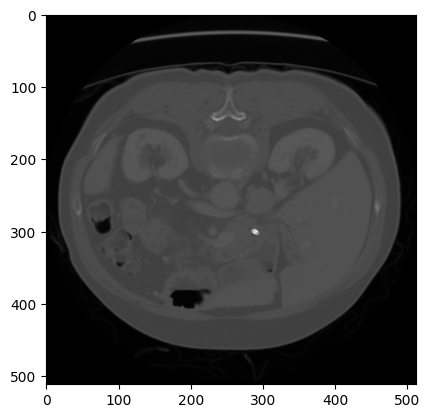

In [25]:
import matplotlib.pyplot as plt

plt.imshow((npy_image[50, :, :]), cmap='gray')
plt.show()

In [18]:
import numpy as np
np.unique(npy_image)

array([0, 1, 2], dtype=uint8)

In [1]:
from dataloaders.MSD import (MSD, CenterCrop, RandomCrop,
                                   RandomRotFlip, ToTensor,
                                   TwoStreamBatchSampler)
from torchvision import transforms

db_train = MSD(base_dir="/home/major/Major-Project-Experiments/SSL4MIS/data/MSD",
                         split='train',
                         num=None,
                         transform=transforms.Compose([
                             RandomRotFlip(),
                             RandomCrop([96, 96, 96]),
                             ToTensor(),
                         ])) 

total 363 samples


In [2]:
import random
from torch.utils.data import DataLoader
def worker_init_fn(worker_id):
    random.seed(0 + worker_id)

labeled_idxs = list(range(0, 224))
# Needs to change, increase the number of samples --  Madhav
unlabeled_idxs = list(range(224, 364))
batch_sampler = TwoStreamBatchSampler(
    labeled_idxs, unlabeled_idxs, 4, 4-2)

trainloader = DataLoader(db_train, batch_sampler=batch_sampler,
                            num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

In [36]:
# Preprocessing the label masks to make the pancreas problem a 2 class classification problems
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
images = []
spacings = []
origins = []
directions = []

input_path = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/labelsTr/"
output_path = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/processed_labelsTr/"

for image in os.listdir(input_path):
    itk_image = sitk.ReadImage(input_path + image)
    npy_image = sitk.GetArrayFromImage(itk_image)
    processed_image = np.array((npy_image == 2), dtype=int)
    result_image = sitk.GetImageFromArray(processed_image)
    result_image.CopyInformation(itk_image)
    sitk.WriteImage(result_image, output_path + image)


# plt.imshow(npy_image[30, :, :] == 2, cmap='gray')

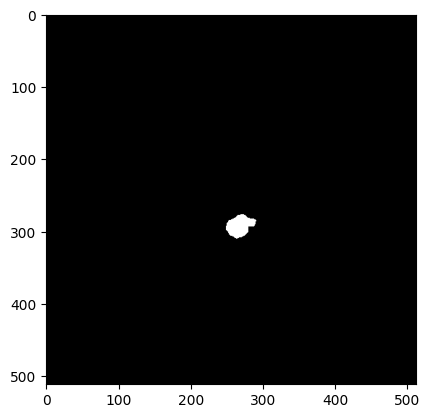

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os

images = []
spacings = []
origins = []
directions = []


itk_image = sitk.ReadImage("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/processed_labelsTr/pancreas_001.nii.gz")
# print(itk_image.GetSpacing())
# print(itk_image.GetOrigin())
# print(itk_image.GetDirection())
npy_image = sitk.GetArrayFromImage(itk_image)
plt.imshow(npy_image[50, :, :], cmap='gray')

In [4]:
print(binary_image[50, :, :])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(113, 512, 512)
(512, 512, 1)
(512, 512, 1)
<class 'numpy.ndarray'>


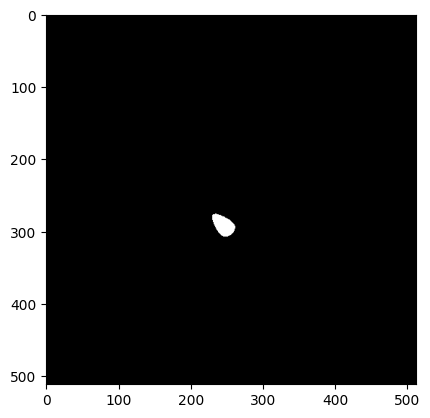

(230.0, 276.0)


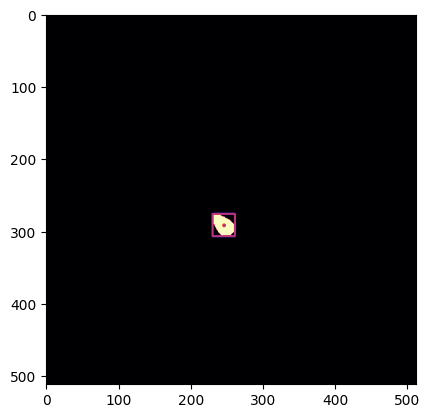

In [2]:
# Check if the bboxes are correct

import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Load the nii.gz image
image = sitk.ReadImage('/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/processed_labelsTr/pancreas_269.nii.gz')
binary_image = sitk.GetArrayFromImage(image)

# Ensure it's binary (using 0 as the threshold for simplicity)
# binary_image = np.where(image_array > 0, 1, 0)

print(binary_image.shape)

# Find contours (slight change from pure OpenCV here)
# for index in range(binary_image.shape[0]):

nonzero_indices = np.nonzero(binary_image[44, :, :])  # Equivalent to np.where(data == 1)

# print(nonzero_indices)

# Maximum and minimum x-indices (column indices)
max_x = nonzero_indices[1].max()
min_x = nonzero_indices[1].min()

# Maximum and minimum y-indices (row indices)
max_y = nonzero_indices[0].max()
min_y = nonzero_indices[0].min()

# Iterate through contours, get bounding boxes, and draw
# for cnt in contours:
# x, y, w, h = cv2.boundingRect(cnt)
# xmin = x
# xmax = x + w
# ymin = y
# ymax = y + h
# binary_image = binary_image*255
# print(np.unique(binary_image))

img = binary_image[44, :, :]
img = np.reshape(img, (img.shape[0], img.shape[1], 1))
img = img*255


img = np.ascontiguousarray(img, dtype=np.uint8)

print(img.shape)
# img = img.transpose(1, 2, 0)
print(img.shape)
print(type(img))
plt.imshow(img, cmap='gray')
plt.show()
# Getting the bbox from the text file
(clas, cx, cy, w, h) = map(float, open("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/labels/pancreas_269/pancreas_269_44.txt", 'r').read().strip().split(' '))
print((cx-w/2, cy-h/2))
cv2.rectangle(img, (round(cx-w/2), round(cy-h/2)), (round(cx+w/2), round(cy+h/2)), (128, 128, 128), 2)  # Green box
cv2.circle(img, (round(cx), round(cy)),1,(128, 128, 128), 2)

# # Display the image with bounding boxes
plt.imshow(img, cmap='magma')
plt.show()
    # break

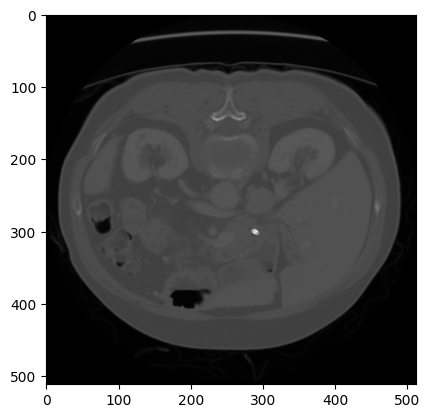

In [15]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

# Load the nii.gz image
image = sitk.ReadImage('/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/pancreas_001_0000.nii.gz')
image_array = sitk.GetArrayFromImage(image)
np.unique(image_array)
img = image_array[50, :, :]
plt.imshow(img, cmap='gray')

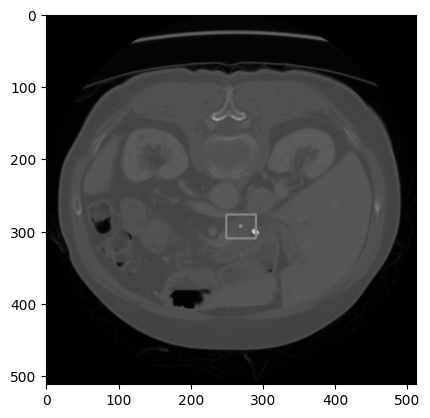

In [16]:
img = np.reshape(img, (img.shape[0], img.shape[1], 1))
img = (img - np.min(img))/(np.max(img)-np.min(img))
img = img*255
img = np.ascontiguousarray(img, dtype=np.uint8)
cv2.rectangle(img, (min_x, min_y), (max_x, max_y), (128, 128, 128), 2)  # Green box
cv2.circle(img, ((min_x+max_x)//2, (min_y+max_y)//2),1,(128, 128, 128), 2)

# # Display the image with bounding boxes
plt.imshow(img, cmap='gray')
plt.show()

In [14]:
print(min_x, max_x, min_y, max_y)

249 290 277 310


In [11]:
np.unique(img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Final code to get the yolo format

In [4]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# img_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr"
label_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/processed_labelsTr"
output_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/labels"
label_cnt_file = open('label_cnt_file.txt', 'w')

for label in tqdm(os.listdir(label_folder)):
    label_file = sitk.ReadImage(os.path.join(label_folder, label))
    binary_label = sitk.GetArrayFromImage(label_file)

    if not np.all(np.isin(np.unique(binary_label), ([0, 1]))):
        print(np.unique(binary_label))
        raise Exception("The label contains values other that 0 and 1")

    # Ensure it's binary (using 0 as the threshold for simplicity)
    # binary_label = np.where(label_array > 0, 1, 0)

    # print(binary_label.shape)

    # Find contours (slight change from pure OpenCV here)
    # for index in range(binary_image.shape[0]):

    if not os.path.exists(os.path.join(output_folder, label.split('.')[0])):
        os.makedirs(os.path.join(output_folder, label.split('.')[0]))

    label_cnt = 0
    nonlabel_cnt = 0

    for idx in range(binary_label.shape[0]):
        nonzero_indices = np.nonzero(binary_label[idx, :, :])  # Equivalent to np.where(data == 1)

        # print(nonzero_indices)
        with open(os.path.join(output_folder, label.split('.')[0], label.split('.')[0]+'_'+str(idx)+'.txt'), 'w') as f:
            try:
                # Maximum and minimum x-indices (column indices)
                max_x = nonzero_indices[1].max()
                min_x = nonzero_indices[1].min()

                # Maximum and minimum y-indices (row indices)
                max_y = nonzero_indices[0].max()
                min_y = nonzero_indices[0].min()

                file_arr = np.array([[0, (min_x+max_x)/2, (min_y+max_y)/2, max_x-min_x, max_y-min_y]])
                np.savetxt(f, file_arr, fmt='%.3f', delimiter=' ')
                label_cnt += 1
            except:
                nonlabel_cnt += 1
                pass
    label_cnt_file.write(label+' '+str(label_cnt)+' '+str(nonlabel_cnt)+'\n')
    break
label_cnt_file.close()

  0%|          | 0/281 [00:02<?, ?it/s]


Final code to change CT images to jpeg

In [ ]:
import cv2
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

img_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr"
# label_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/processed_labelsTr"
output_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/images"

for img_file in os.listdir(img_folder):
    image = sitk.ReadImage(os.path.join(img_folder, img_file))
    image_np = sitk.GetArrayFromImage(image)

    for idx in range(image_np.shape[0]):
        # nonzero_indices = np.nonzero(binary_label[idx, :, :])  # Equivalent to np.where(data == 1)
        img = image_np[idx, :, :]
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
        img = (img - np.min(img))/(np.max(img)-np.min(img))
        img = img*255
        img = np.ascontiguousarray(img, dtype=np.uint8)
        out_filename = ('_').join(img_file.split('_')[:-1])
        if not os.path.exists(os.path.join(output_folder, out_filename)):
            os.makedirs(os.path.join(output_folder, out_filename))
        out_path = os.path.join(output_folder, out_filename, out_filename+'_'+str(idx)+'.jpeg')
        # print(out_path)
        # plt.imshow(img)
        # plt.show()

        cv2.imwrite(out_path, img)

In [ ]:
labelled = 0
unlabelled = 0
with open('/home/major/Major-Project-Experiments/label_cnt_file.txt', 'r') as f:
    lines = f.read().strip().split('\n')
    for idx in range(len(lines)):
        line = lines[idx]
        print(line)
        line = line.strip().split()
        print(line)
        labelled += int(line[1])
        unlabelled += int(line[2])

In [5]:
print(labelled)
print(unlabelled)

2537
24182


In [ ]:
for folder in os.listdir("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/labels"):
    

In [3]:
arr = open("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/labels/pancreas_001/pancreas_001_40.txt", "r").read().strip()

In [4]:
arr

'0.000 0.531 0.586 0.102 0.098'

In [ ]:
import os
import random
import numpy as np

random.seed(10)

label_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/labels"
detections_arr = []
background_arr = []
for patient in os.listdir(label_folder):
    detections = []
    background = []
    for slice in os.listdir(os.path.join(label_folder, patient)):
        file_content = open(os.path.join(label_folder, patient, slice), 'r').read().strip()
        if file_content == '':
            background.append(os.path.join(label_folder, patient, slice))
        else:
            detections.append(os.path.join(label_folder, patient, slice))
    random.shuffle(background)
    random.shuffle(detections)
    idx = int(0.01*len(background))+1
    background = background[0:idx]
    detections_arr.extend(detections)
    background_arr.extend(background)
detections_arr = np.array(detections_arr)
background_arr = np.array(background_arr)

np.savetxt('detections.txt', detections_arr, '%s', ' ', '\n')
np.savetxt('background.txt', background_arr, '%s', ' ', '\n')

In [12]:
with open('/home/major/Major-Project-Experiments/test_yolo.txt', 'w') as f:
    detections = open('/home/major/Major-Project-Experiments/detections.txt', 'r').read().strip().split('\n')
    backgrounds = open('/home/major/Major-Project-Experiments/background.txt', 'r').read().strip().split('\n')
    # train_file = open('/home/major/Major-Project-Experiments/train.txt', 'r').read().strip()
    test_file = open('/home/major/Major-Project-Experiments/test.txt', 'r').read().strip()
    detection_cnt = 0
    background_cnt = 0
    for detection in detections:
        if detection.split('/')[-2] in test_file:
            f.write(detection+'\n')
            detection_cnt += 1
    for background in backgrounds:
        if background.split('/')[-2] in test_file:
            f.write(background+'\n')
            background_cnt += 1
print(detection_cnt)
print(background_cnt)

509
63


In [20]:
# Copying the files 

import shutil
from tqdm import tqdm
import os

train_list = open('/home/major/Major-Project-Experiments/train_yolo.txt', 'r').read().strip().split('\n')
test_list = open('/home/major/Major-Project-Experiments/test_yolo.txt', 'r').read().strip().split('\n')

for train_label in tqdm(train_list):
    if not os.path.exists(('/').join(train_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1])):
        os.makedirs(('/').join(train_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1]))
    shutil.copy(train_label, train_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset'))
    train_file = train_label.replace('/labels/', '/images/').replace('txt', 'jpeg')
    # print(train_file)
    # print(('/').join(train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1]))
    if not os.path.exists(('/').join(train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1])):
        os.makedirs(('/').join(train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1]))
    shutil.copy(train_file, train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset'))

for test_label in tqdm(test_list):
    if not os.path.exists(('/').join(test_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1])):
        os.makedirs(('/').join(test_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1]))
    shutil.copy(test_label, test_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset'))
    test_file = test_label.replace('/labels/', '/images/').replace('txt', 'jpeg')
    # print(train_file)
    # print(('/').join(train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1]))
    if not os.path.exists(('/').join(test_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1])):
        os.makedirs(('/').join(test_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-1]))
    shutil.copy(test_file, test_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset'))

/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/preprocessed_labelsTr_bbox/images/pancreas_370/pancreas_370_61.jpeg
/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/final_yolo_dataset/images/pancreas_370


In [1]:
# Copying the files in yolo format

import shutil
from tqdm import tqdm
import os

train_list = open('/home/major/Major-Project-Experiments/train_yolo.txt', 'r').read().strip().split('\n')
test_list = open('/home/major/Major-Project-Experiments/test_yolo.txt', 'r').read().strip().split('\n')

for train_label in tqdm(train_list):
    train_label_output = ('/').join(train_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-2]) + '/train/' + train_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[-1]
    shutil.copy(train_label, train_label_output)
    train_file = train_label.replace('/labels/', '/images/').replace('txt', 'jpeg')
    train_file_output = ('/').join(train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-2]) + '/train/' + train_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[-1]
    shutil.copy(train_file, train_file_output)
    break

for test_label in tqdm(test_list):
    test_label_output = ('/').join(test_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-2]) + '/val/' + test_label.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[-1]
    shutil.copy(test_label, test_label_output)
    test_file = test_label.replace('/labels/', '/images/').replace('txt', 'jpeg')
    test_file_output = ('/').join(test_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[:-2]) + '/val/' + test_file.replace('preprocessed_labelsTr_bbox', 'final_yolo_dataset').split('/')[-1]
    shutil.copy(test_file, test_file_output)
    break

  0%|          | 0/572 [00:00<?, ?it/s]


In [1]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
results = model.train(data='/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/final_yolo_dataset/data.yaml', epochs=100, imgsz=640)

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

Ultralytics YOLOv8.1.30 🚀 Python-3.10.12 torch-1.11.0+cu113 CUDA:0 (Tesla V100S-PCIE-32GB, 32501MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/final_yolo_dataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, ret

2024-03-21 12:25:43.521989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 12:25:43.522137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 12:25:43.563458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.